# FAST START

In [1]:
import os
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}
if os.name=='nt':
    !pip install wget
    import wget
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 
import object_detection
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
labels = [{'name':'licence', 'id':1}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config) 
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]
config_text = text_format.MessageToString(pipeline_config)    
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-21')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
import easyocr
detection_threshold = 0.7

100% [..........................................................................] 1468733 / 1468733ЏҐаҐ¬ҐйҐ­® д ©«®ў:         1.
‘Є®ЇЁа®ў ­® д ©«®ў:         1.
running build
running build_py
copying object_detection\protos\anchor_generator_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\argmax_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\bipartite_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_coder_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_predictor_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\calibration_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\center_net_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\eval_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\faster_rcnn_box_coder_pb2.py -> build\lib\object_detection\protos
c

D:\ANPR\anprsys\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
D:\ANPR\anprsys\lib\site-packages\setuptools\command\easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
zip_safe flag not set; analyzing archive contents...
object_detection.core.__pycache__.densepose_ops.cpython-310: module references __file__
object_detection.core.__pycache__.preprocessor.cpython-310: module MAY be using inspect.stack
object_detection.utils.__pycache__.autoaugment_utils.cpython-310: module MAY be using inspect.stack
No local packages or working download links found for tensorflow-text~=2.11.0
error: Could not find suitable distribution for Requirement.parse('tensorflow-text~=2.11.0')


Obtaining file:///D:/ANPR/Tensorflow/models/research/slim
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: slim
    Found existing installation: slim 0.1
    Uninstalling slim-0.1:
      Successfully uninstalled slim-0.1
  Running setup.py develop for slim


100% [........................................................................] 20515344 / 20515344ЏҐаҐ¬ҐйҐ­® д ©«®ў:         1.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record


Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


‘Є®ЇЁа®ў ­® д ©«®ў:         1.


In [1]:
!pip freeze

absl-py==1.3.0
anyio==3.6.2
apache-beam==2.43.0
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asttokens==2.2.0
astunparse==1.6.3
attrs==22.1.0
avro-python3==1.10.2
backcall==0.2.0
beautifulsoup4==4.11.1
bleach==5.0.1
cachetools==5.2.0
certifi==2022.9.24
cffi==1.15.1
charset-normalizer==2.1.1
cloudpickle==2.2.0
colorama==0.4.6
contextlib2==21.6.0
contourpy==1.0.6
crcmod==1.7
cycler==0.11.0
Cython==0.29.32
debugpy==1.6.4
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.1.1
dm-tree==0.1.7
docopt==0.6.2
easyocr==1.6.2
entrypoints==0.4
etils==0.9.0
executing==1.2.0
fastavro==1.7.0
fasteners==0.18
fastjsonschema==2.16.2
flatbuffers==22.12.6
fonttools==4.38.0
gast==0.4.0
gin-config==0.5.0
google-api-core==2.11.0
google-api-python-client==2.68.0
google-auth==2.15.0
google-auth-httplib2==0.1.0
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
googleapis-common-protos==1.57.0
grpcio==1.51.1
grpcio-tools==1.51.1
h5py==3.7.0
hdfs==2.7.0
httplib2==0.20.4
idna==3.4
imageio==2.22.4
immutabledict==2.2.3


# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [6]:
# https://www.tensorflow.org/install/source_windows

In [6]:
if os.name=='nt':
    !pip install wget
    import wget


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [8]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

100% [..........................................................................] 1468733 / 1468733ЏҐаҐ¬ҐйҐ­® д ©«®ў:         1.
‘Є®ЇЁа®ў ­® д ©«®ў:         1.
running build
running build_py
copying object_detection\protos\anchor_generator_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\argmax_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\bipartite_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_coder_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_predictor_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\calibration_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\center_net_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\eval_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\faster_rcnn_box_coder_pb2.py -> build\lib\object_detection\protos
c

D:\ANPR\anprsys\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
D:\ANPR\anprsys\lib\site-packages\setuptools\command\easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
zip_safe flag not set; analyzing archive contents...
object_detection.core.__pycache__.densepose_ops.cpython-310: module references __file__
object_detection.core.__pycache__.preprocessor.cpython-310: module MAY be using inspect.stack
object_detection.utils.__pycache__.autoaugment_utils.cpython-310: module MAY be using inspect.stack
No local packages or working download links found for tensorflow-text~=2.11.0
error: Could not find suitable distribution for Requirement.parse('tensorflow-text~=2.11.0')


Obtaining file:///D:/ANPR/Tensorflow/models/research/slim
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: slim
    Found existing installation: slim 0.1
    Uninstalling slim-0.1:
      Successfully uninstalled slim-0.1
  Running setup.py develop for slim



[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install tensorflow==2.10

In [31]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2023-06-06 16:52:05.832942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-06-06 16:52:05.832969: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-06 16:52:08.661637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-06-06 16:52:08.662020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2023-06-06 16:52:08.662340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2023-06-06 16:52:08.662645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu

In [ ]:
!pip install tensorflow --upgrade

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [11]:
import object_detection

In [11]:
!pip list

Package                       Version     Editable project location
----------------------------- ----------- ---------------------------------------
absl-py                       1.3.0
anyio                         3.6.2
apache-beam                   2.43.0
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.2.0
astunparse                    1.6.3
attrs                         22.1.0
avro-python3                  1.10.2
backcall                      0.2.0
beautifulsoup4                4.11.1
bleach                        5.0.1
cachetools                    5.2.0
certifi                       2022.9.24
cffi                          1.15.1
charset-normalizer            2.1.1
cloudpickle                   2.2.0
colorama                      0.4.6
contextlib2                   21.6.0
contourpy                     1.0.6
crcmod                        1.7
cycler                        0.11.0
Cython                        0.29.32
debugpy  


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

100% [........................................................................] 20515344 / 20515344ЏҐаҐ¬ҐйҐ­® д ©«®ў:         1.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


# 2. Create Label Map

In [9]:
labels = [{'name':'licence', 'id':1}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [10]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [11]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [12]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record


Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Model Config to Training Folder

In [13]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

‘Є®ЇЁа®ў ­® д ©«®ў:         1.


# 5. Update Config For Transfer Learning

In [14]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [19]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [20]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [21]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [22]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [23]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [ ]:
!pip install tensorflow==2.10

# 6. Train the model

In [23]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [24]:
!pip install tensorflow==2.9.1 --user

^C


In [24]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=20000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [25]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=20000


In [32]:
!{command}

^C


# 7. Evaluate the Model

In [28]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [29]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


In [30]:
!{command}

^C


# 8. Load Train Model From Checkpoint

In [15]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [16]:
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [17]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-21')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [2]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [4]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', '1197499.jpg')

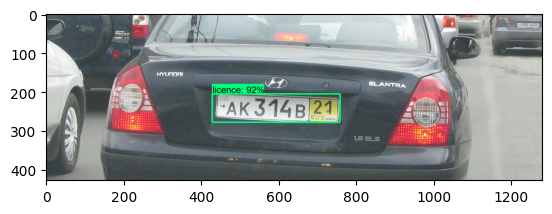

In [5]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
import easyocr

In [7]:
detection_threshold = 0.7

In [8]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [9]:
width = image.shape[1]
height = image.shape[0]

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[34, 12], [112, 12], [112, 62], [34, 62]], 'AK =', 0.23518280275476142), ([[99, 0], [256, 0], [256, 72], [99, 72]], '314B]', 0.6484274235009605), ([[251, 51], [293, 51], [293, 69], [251, 69]], 'RUS', 0.9940175425569117), ([[256, 10], [316, 10], [316, 58], [256, 58]], '27', 0.9799352812038125)]


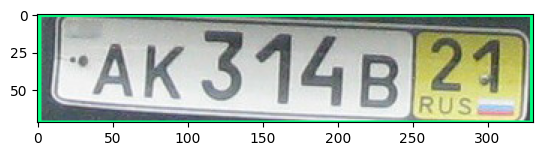

In [10]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    roi = box*[height, width, height, width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [11]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

50
AK =
72
314B]
18
RUS
48
27


In [12]:
region_threshold = 0.15

In [13]:
#OCR FILTERING
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [14]:
OCR_Result = filter_text(region, ocr_result, region_threshold)
Result1 = ''.join(OCR_Result)
Result1 = Result1.translate({ord(' '): None})
Result1 = Result1.translate({ord('='): None})
Result1 = Result1.translate({ord('.'): None})
Result1 = Result1.translate({ord(','): None})
Result1 = Result1.translate({ord('/'): None})
Result1 = Result1.translate({ord('@'): None})
Result1 = Result1.translate({ord('#'): None})
Result1 = Result1.translate({ord('$'): None})
Result1 = Result1.translate({ord('%'): None})
Result1 = Result1.translate({ord('^'): None})
Result1 = Result1.translate({ord('&'): None})
Result1 = Result1.translate({ord('*'): None})
Result1 = Result1.translate({ord('['): None})
Result1 = Result1.translate({ord(']'): None})
Result1 = Result1.translate({ord('!'): None})
#(region, ocr_result, region_threshold)

In [15]:
print(Result1)

AK314B


In [40]:
import grpc
import LicenseService_pb2
import LicenseService_pb2_grpc
PlateRequest = Result1
with grpc.insecure_channel('localhost:8989') as channel:
	stub = LicenseService_pb2_grpc.LicensePlateServiceStub(channel)
	response = stub.greeting(LicenseService_pb2.LicensePlateRequest(PlateRequest=Result1))
    

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses; last error: UNAVAILABLE: ipv4:127.0.0.1:8989: WSA Error"
	debug_error_string = "UNKNOWN:failed to connect to all addresses; last error: UNAVAILABLE: ipv4:127.0.0.1:8989: WSA Error {created_time:"2023-06-07T07:02:01.332981124+00:00", grpc_status:14}"
>

In [16]:
#FINAL FUNCTION
region_threshold = 0.15

In [17]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


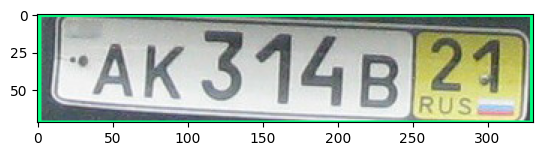

['AK =', '314B]']


In [18]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# 10. Real Time Detections from your Webcam

In [91]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.builders import model_builder

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-21')).expect_partial()

# Get input tensor shape
inputs = tf.keras.Input(shape=(320, 320, 3))

# Create a TensorFlow Keras model from detection model
output_dict = detection_model(inputs, training=False)
keras_model = tf.keras.models.Model(inputs=inputs, outputs=output_dict)
    
# Print the model summary
keras_model.summary()


Instructions for updating:
Use fn_output_signature instead
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 320, 320, 3)]     0         
                                                                 
 ssd_meta_arch_26 (SSDMetaAr  {'detection_boxes': (Non  2598116  
 ch)                         e, 100, 4),                         
                              'detection_scores': (No            
                             ne, 100),                           
                              'detection_classes': (N            
                             one, 100),                          
                              'num_detections': (None            
                             ,),                                 
                              'raw_detection_boxes':             
                             (None, None, 4),                    
  

In [86]:
1

AttributeError: 'SSDMetaArch' object has no attribute 'checkpoint_name'

In [63]:
model_test.summary()

AttributeError: summary

In [41]:
model_test.ListFields()

[(<google.protobuf.pyext._message.FieldDescriptor at 0x16b9af283d0>,
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 320
      width: 320
    }
  }
  feature_extractor {
    type: "ssd_mobilenet_v2_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 3.9999998989515007e-05
        }
      }
      initializer {
        random_normal_initializer {
          mean: 0.0
          stddev: 0.009999999776482582
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    use_depthwise: true
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
      additional_layer_depth: 128
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
 

Connection established, showing all registered plates
admin
A002AA177
AK314B21
M222MM02
T008AO777


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


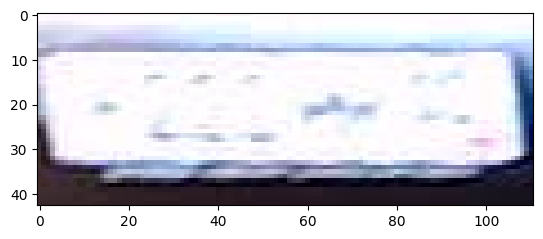

[]
Using OCR to read text...


UnboundLocalError: local variable 'carplate_img' referenced before assignment

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:


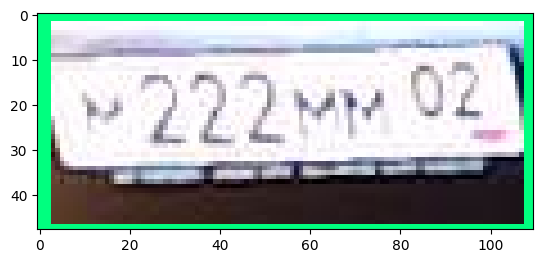

['222702']
Using OCR to read text...


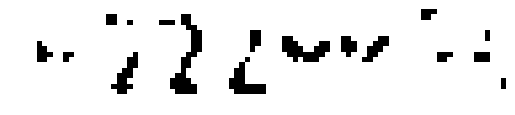

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:222702
TesseractOCR:
Done reading
Searching DB for the same plate...
PR1: 222702
PR2: 
Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


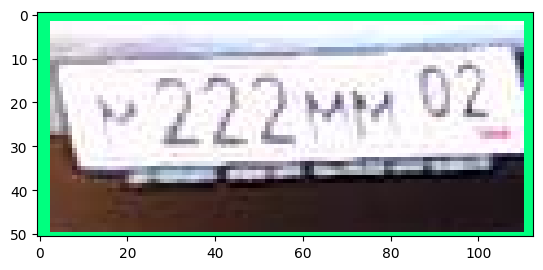

['222+402']
Using OCR to read text...


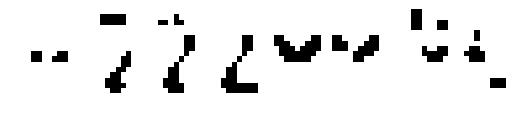

LT4



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:222+402
TesseractOCR:LT4

Done reading
Searching DB for the same plate...
PR1: 222+402
PR2: LT4

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


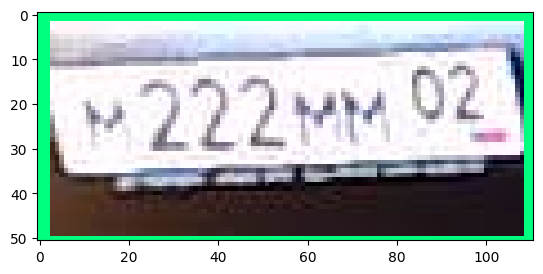

['2221402']
Using OCR to read text...


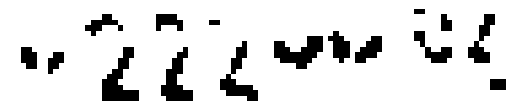

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:2221402
TesseractOCR:
Done reading
Searching DB for the same plate...
PR1: 2221402
PR2: 
Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


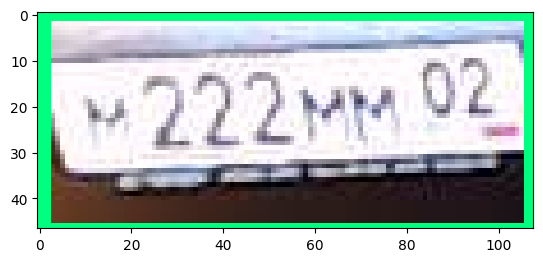

['222144.02']
Using OCR to read text...


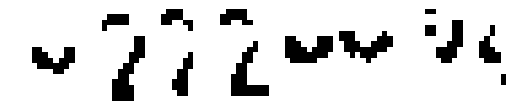

46



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:22214402
TesseractOCR:46

Done reading
Searching DB for the same plate...
PR1: 22214402
PR2: 46

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


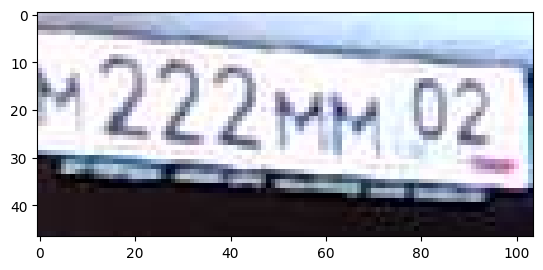

['42220+ 02']
Using OCR to read text...


UnboundLocalError: local variable 'carplate_img' referenced before assignment

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:42220+02
TesseractOCR:46

Done reading
Searching DB for the same plate...
PR1: 42220+02
PR2: 46

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


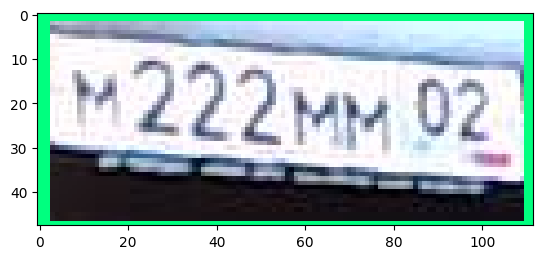

['0222M+ 02']
Using OCR to read text...


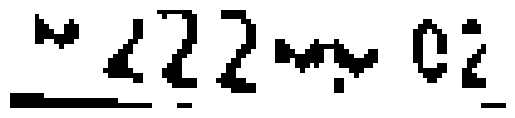

MCE



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:0222M+02
TesseractOCR:MCE

Done reading
Searching DB for the same plate...
PR1: 0222M+02
PR2: MCE

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


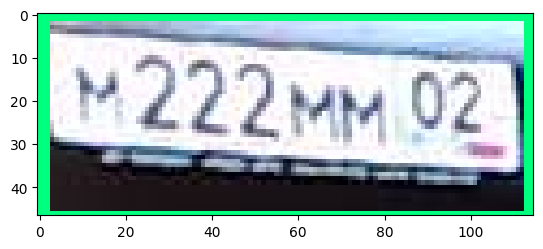

['+222MM 02']
Using OCR to read text...


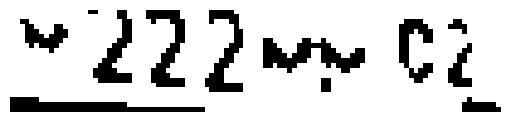

MLL2MCE



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:+222MM02
TesseractOCR:MLL2MCE

Done reading
Searching DB for the same plate...
PR1: +222MM02
PR2: MLL2MCE

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


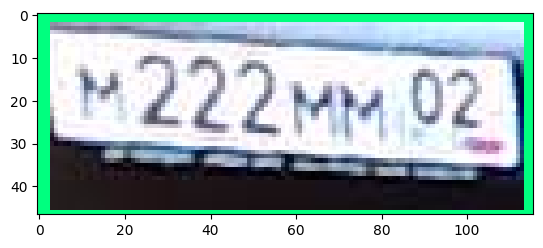

['K222mM 02']
Using OCR to read text...


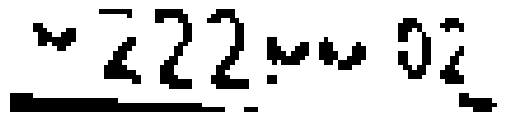

ML



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:K222mM02
TesseractOCR:ML

Done reading
Searching DB for the same plate...
PR1: K222mM02
PR2: ML

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


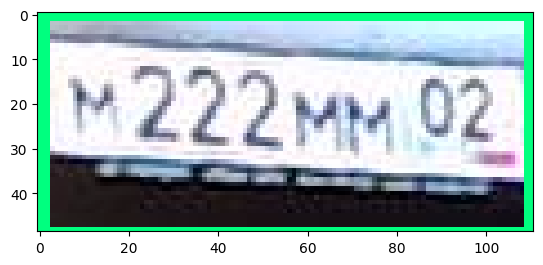

['K222M 02']
Using OCR to read text...


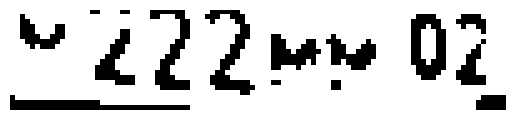

ML07



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:K222M02
TesseractOCR:ML07

Done reading
Searching DB for the same plate...
PR1: K222M02
PR2: ML07

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


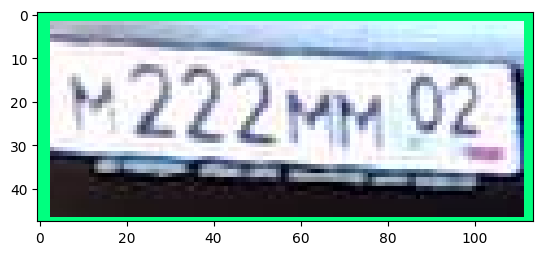

['0222vM.02']
Using OCR to read text...


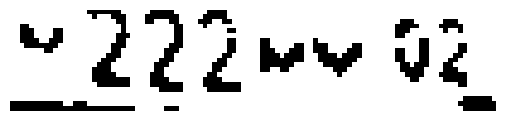

V9Z



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:0222vM02
TesseractOCR:V9Z

Done reading
Searching DB for the same plate...
PR1: 0222vM02
PR2: V9Z

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


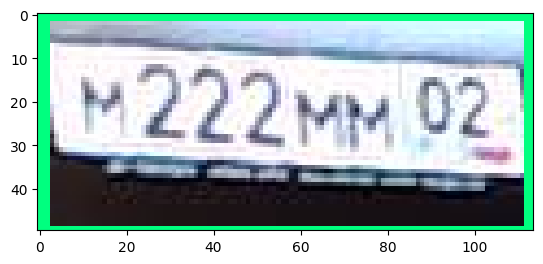

['M2220 02']
Using OCR to read text...


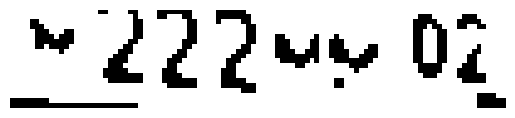

24407

EasyOCR:M222002
TesseractOCR:24407

Done reading
Searching DB for the same plate...
PR1: M222002
PR2: 24407

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


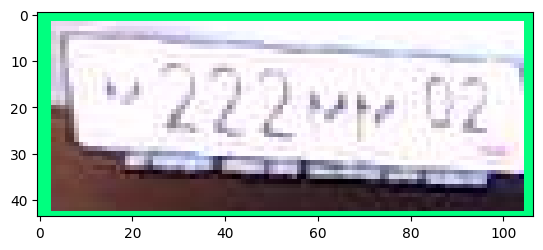

["'27"]
Using OCR to read text...


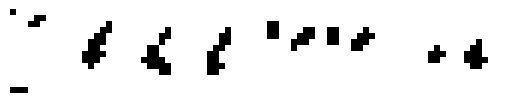

2



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:'27
TesseractOCR:2

Done reading
Searching DB for the same plate...
PR1: '27
PR2: 2

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


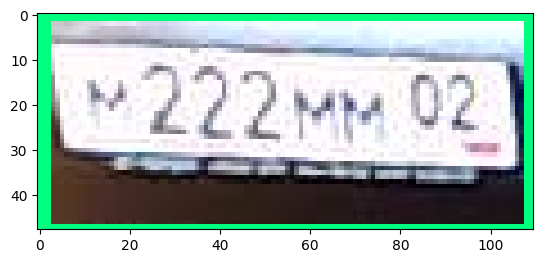

['222m 02']
Using OCR to read text...


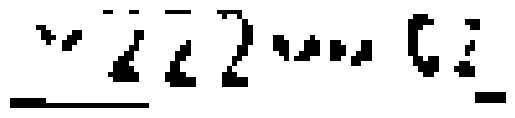

MG



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:222m02
TesseractOCR:MG

Done reading
Searching DB for the same plate...
PR1: 222m02
PR2: MG

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


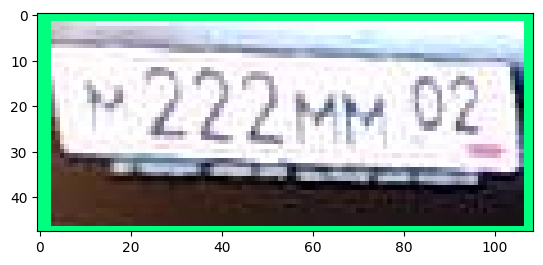

["'222mt 02"]
Using OCR to read text...


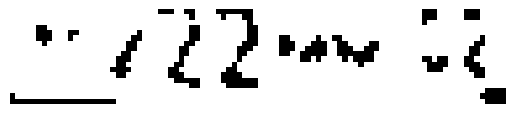

EEL0



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:'222mt02
TesseractOCR:EEL0

Done reading
Searching DB for the same plate...
PR1: '222mt02
PR2: EEL0

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


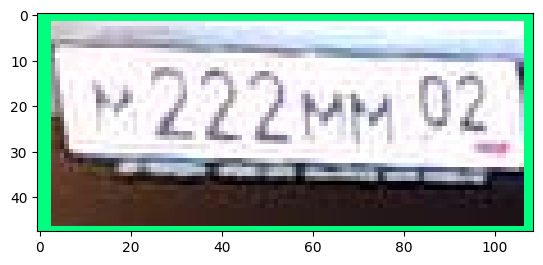

['K2ZZmm 02']
Using OCR to read text...


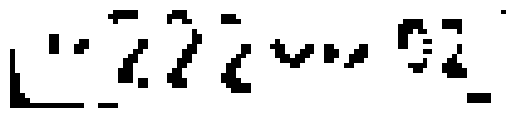

G



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:K2ZZmm02
TesseractOCR:G

Done reading
Searching DB for the same plate...
PR1: K2ZZmm02
PR2: G

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


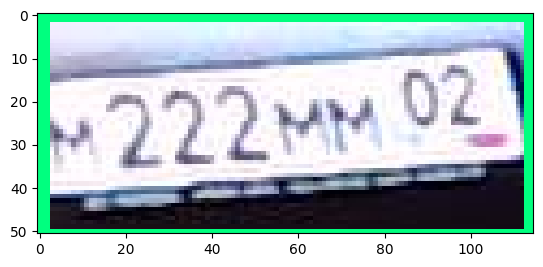

['6222*']
Using OCR to read text...


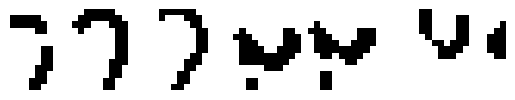

3V



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:6222
TesseractOCR:3V

Done reading
Searching DB for the same plate...
PR1: 6222
PR2: 3V

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


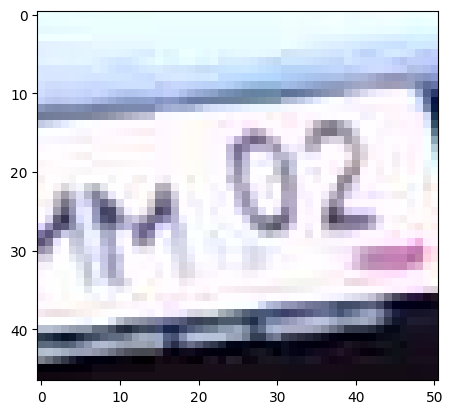

['402']
Using OCR to read text...


UnboundLocalError: local variable 'carplate_img' referenced before assignment

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:402
TesseractOCR:3V

Done reading
Searching DB for the same plate...
PR1: 402
PR2: 3V

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


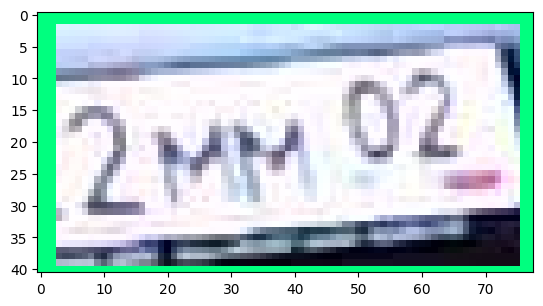

['2m02']
Using OCR to read text...


UnboundLocalError: local variable 'carplate_img' referenced before assignment

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:2m02
TesseractOCR:3V

Done reading
Searching DB for the same plate...
PR1: 2m02
PR2: 3V

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


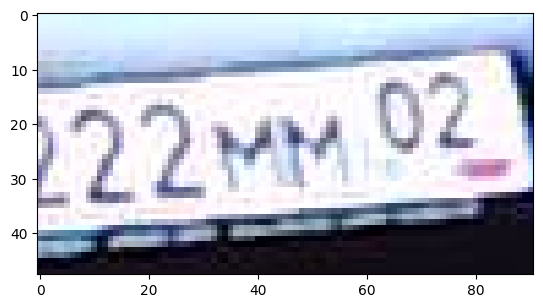

['221.02']
Using OCR to read text...


UnboundLocalError: local variable 'carplate_img' referenced before assignment

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR:22102
TesseractOCR:3V

Done reading
Searching DB for the same plate...
PR1: 22102
PR2: 3V

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


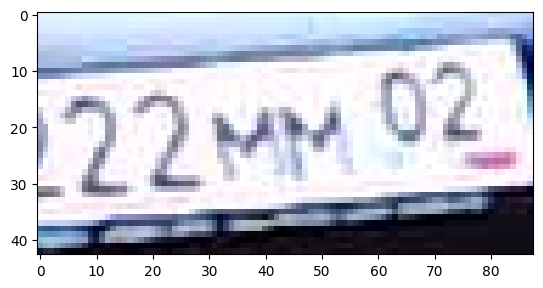

['221.02']
Using OCR to read text...


UnboundLocalError: local variable 'carplate_img' referenced before assignment

EasyOCR:22102
TesseractOCR:3V

Done reading
Searching DB for the same plate...
PR1: 22102
PR2: 3V

Now testing plate: admin
Now testing plate: A002AA177
Now testing plate: AK314B21
Now testing plate: M222MM02
Now testing plate: T008AO777


<Figure size 640x480 with 0 Axes>

In [19]:
import time
import grpc
import mysql.connector
import LicenseService_pb2
import LicenseService_pb2_grpc
import TesseractReader as tr
from PIL import Image
import numpy as np
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="passw0rd",
  database="users"  
)
mycursor = mydb.cursor()
mycursor.execute("SELECT plateref FROM car_table")
myresult = mycursor.fetchall()
if mydb.is_connected():
    print("Connection established, showing all registered plates")
    for x in myresult:
        print(x[0])
while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try: 
        
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        Result2 = ''.join(text)
        Result2 = Result2.translate({ord(' '): None})
        Result2 = Result2.translate({ord('='): None})
        Result2 = Result2.translate({ord('.'): None})
        Result2 = Result2.translate({ord(','): None})
        Result2 = Result2.translate({ord('/'): None})
        Result2 = Result2.translate({ord('@'): None})
        Result2 = Result2.translate({ord('#'): None})
        Result2 = Result2.translate({ord('$'): None})
        Result2 = Result2.translate({ord('%'): None})
        Result2 = Result2.translate({ord('^'): None})
        Result2 = Result2.translate({ord('&'): None})
        Result2 = Result2.translate({ord('*'): None})
        Result2 = Result2.translate({ord(']'): None})
        Result2 = Result2.translate({ord('['): None})
        Result2 = Result2.translate({ord('!'): None})
        PlateRequest = Result2
        print("Using OCR to read text...")
        img = image_np_with_detections
        save_directory = r'D:\ANPR'
        os.chdir(save_directory)
        saved_file_name = "SavedImageWithAPlate.jpg"
        cv2.imwrite(saved_file_name, img)
        %run TesseractReader.py
        time.sleep(2)
        from TesseractReader import *
        print("EasyOCR:" + PlateRequest)
        print("TesseractOCR:" + saved_plate)
        PR1 = PlateRequest
        PR2 = saved_plate
        print("Done reading")
        mycursor = mydb.cursor()
        mycursor.execute("SELECT plateref FROM car_table")
        myresult = mycursor.fetchall()
        if mydb.is_connected():
            print("Searching DB for the same plate...")
            print("PR1: " + PR1)
            print("PR2: " + PR2)
            for y in myresult:
                print("Now testing plate: " + y[0])
                if(y[0]==PR1 or y[0]==PR2):
                    print("Registered plate detected, sending GRPC request")
                    directory = r'C:\auto_model\data\test'
                    img = image_np_with_detections
                    os.chdir(directory)
                    filename = 'testimg.jpg'
                    cv2.imwrite(filename, img)
                    directory = r'C:\auto_model'
                    os.chdir(directory)
                    os.system("start cmd /k python demo.py")
                    time.sleep(12)
                    with grpc.insecure_channel('localhost:8989') as channel:
                        stub = LicenseService_pb2_grpc.LicensePlateServiceStub(channel)
                        response = stub.greeting(LicenseService_pb2.LicensePlateRequest(PlateRequest=Result2))
                    save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break